# Bees? Bees!  
----Image Classification using Spark
<img width=200 height=200 src="bee_background.png"/>
#### Team members:
Xingchi Dai: dai01@g.harvard.edu

Jeewon Hwang: jeewonHwang@g.harvard.edu

Xiaowen Chang: xiaowenchang@g.harvard.edu

Instructor and assigned Teaching fellow: 

Dr. Thouis (Ray) 
Jones Adi Peleg

###### Submitted as the final project of cs205: parallel computing foundation in Harvard University


# Table of Contents

* [0. Introduction](#0.-Introduction)
* [1. Image Processing for Training Data set](#1.-Image-Processing-for-Training-Data-set)
    * [1.1 Sliding Window](#1.1-Sliding-Window)
    * [1.2 Labelling Window](#1.2-Labelling-Window)
    * [1.3 Flattening Window](#1.3-Flattening-Window)
        * [1.3.1 Serialized Version of Flattening Window](#1.3.1-Serialized-Version-of-Flattening-Window)
        * [1.3.2 Parallelized Version of Flattening Window](#1.3.2-Parallelized-Version-of-Flattening-Window)
        * [1.3.3 Performance Testing of Flattening Window](#1.3.3-Performance-Testing-of-Flattening-Window)
* [2. Classification using Training Data set](#2.-Classification-using-Training-Data-set)
    * [2.1 Serialized Version with External Library](#2.1-Serialized-Version-with-External-Library)
        * [2.1.1 PCA](#2.1.1-PCA)
        * [2.1.2 KNN](#2.1.2-KNN)
        * [2.1.3 Logistic Regression](#2.1.3-Logistic-Regression)
        * [2.1.4 Model Comparison using ROC Curve](#2.1.4-Model-Comparison-using-ROC-Curve)
    * [2.2 Serialized Implementation](#2.2-Serialized-Implementation)
        * [2.2.1 PCA](#2.2.1-PCA)
        * [2.2.2 KNN](#2.2.2-KNN)
    * [2.3 Parallelized Implementation](#2.3-Parallelized-Implementation)
        * [2.3.1 PCA](#2.3.1-PCA)
        * [2.3.2 KNN](#2.3.2-KNN)
    * [2.4 Performance Testing](#2.4-Performance-Testing)
        * [2.4.1 PCA](#2.4.1-PCA)
        * [2.4.2 KNN](#2.4.2-KNN)
* [3. Image Processing for Whole Data set](#3.-Image-Processing-for-Whole-Data-set)
    * [3.1 Sliding Window](#3.1-Sliding-Window)
    * [3.2 Flattening Window](#3.2-Flattening-Window)
        * [3.3.1 Serialized Version of Flattening Window](#3.3.1-Serialized-Version-of-Flattening-Window)
        * [3.3.2 Parallelized Version of Flattening Window](#3.3.2-Parallelized-Version-of-Flattening-Window)
        * [3.3.3 Performance Testing of Flattening Window](#3.3.3-Performance-Testing-of-Flattening-Window)
* [4. Apply Classifier to Whole Data set](#4.-Apply-Classifier-to-Whole-Data-set)
    * [4.1 PCA Performance Testing](#4.1-PCA-Performance-Testing)
    * [4.2 KNN Performance Testing](#4.2-KNN-Performance-Testing)


# 0. Introduction
### Functionality
detecting and distinguishing objects(bees) in images
### Feature:
detection of the area containing the object (bee) in one image.
### Performance:
less than half an hour

### Motivation
Image is an important data, which contains useful, yet hard to retrieve, information. Many technology companies are trying to develop their own algorithms on processing images accurately to get powerful features, such as face recognition and self-driving cars. This project will implement knowledge taught in CS205, such as parallel computing, spark etc., and other machine learning concepts, such as PCA and KNN classifications to do a fast image processing procedure. 
### Background Researches
1: Parrallel computing algorithm in the image processing

2: Classification algorithms: Principal-Component-Analysis (PCA), K-Nearest-Neighbors (KNN) and Logistic Regression.

3:Metrics to estimate performances: Confusion Matrix and ROC curve

### In-class Knowledge

parallel computing in Spark, MLlib module, image processing


### Verification

#### data

5,000 images, each one contains a honey bee or a bumble bee; a correct label has to be tagged for them. 

#### Train/Test data

Data will be divided into the train dataset and the test dataset. The train dataset would be used to develop the algorithm and the test dataset would be used to evaluate the performance of the algorithm. 

#### Accuracy

Cross-Validation: when estimating the parameters of the model, k-fold cross-validation approach would be applied to avoid over-fitting scenario. 

ROC Curve: we will use ROC curve to do the accuracy evaluation and model comparison.


#### Performance
1: Compare the performance of serialized version and parallelized version of training data (small dataset which only contains 50 images).

2: Compare the performance of parallelized version with different number of partition of training data (small dataset which only contains 50 images).

3: Compare the performance of serialized version and parallelized version of test data. (large dataset which contains 5000 images).

4: Compare the performance of parallelized version with different number of partition of test data (large dataset which contains 5000 images).

# 1. Image Processing for Training Data set

### Coloring and Labeling

The team will use OpenCV in this section. Import all relevant external files.

In [1]:
import cv2
import numpy as np
import glob
import time
WINDOW_SIZE=20
STEP_SIZE=10

In [2]:
import findspark
findspark.init('/Users/Grace/spark-1.5.0-bin-hadoop2.6/')
print findspark.find()

import pyspark
# conf = (pyspark.SparkConf()
#     .setMaster('local')
#     .setAppName('pyspark')
#     .set("spark.executor.memory", "4g")
#     .set("spark.default.parallelism", 10)
#     .set("spark.core.connection.ack.wait.timeout", 120))
# sc = pyspark.SparkContext(conf=conf)

conf = (pyspark.SparkConf()
    .setMaster('local')
    .setAppName('pyspark')
    .set("spark.default.parallelism", 10)
    .set("spark.driver.memory", "2G") 
    .set("spark.executor.memory", "5G") 
    .set("spark.executor.instances", 8) 
    .set("spark.executor.cores", 2)) 
sc = pyspark.SparkContext(conf=conf)

/Users/Grace/spark-1.5.0-bin-hadoop2.6/


#### Read all Images' information

In this section, the images will be read into the variable, mg_oath

All colored images will be imported. There are 50 of them


In [3]:
img_path = '/Users/Grace/colored50/*.jpg'
images = glob.glob(img_path)
img_dict={}

for img_p in images:
    k = img_p[img_p.find('50/',)+3:-4]
    img_dict[k] = cv2.imread(img_p, cv2.IMREAD_COLOR)  ### there's only_blue among image folder... we have to delete and have only 48 images in total...

In [4]:
print len(img_dict) # it should be 50
print img_dict.keys()

50
['2861', '2614', '3713', '2964', '4654', '4413', '3490', '114', '3573', '395', '4454', '485', '2524', '4703', '4148', '879', '747', '3478', '3344', '2741', '1372', '2401', '4588', '4216', '438', '1130', '952', '99', '3178', '3524', '4566', '3649', '4941', '3313', '4052', '2213', '4156', '1046', '4117', '3012', '4507', '940', '2085', '3194', '3844', '1474', '371', '920', '725', '431']


#### Read the "Blue" color RGB matrix

Since "blue" is used for coloring those 50 pictures, the RGB information of Blue color has been stored into the variable. This variable will be used to check if the image contain such blue color, thus to determine if a bee is in the picture.

In [5]:
#read only_blue color into the variable
only_blue = cv2.imread('/Users/Grace/only_blue.jpg')
#as the only blue is not pure, we will have to pick the blue pixel out of it
blue_pixel_rgb = only_blue[100][1]

#### The picture size

The picture size we used contain 200 * 200 pixels, the following result proves this. Each pixel is a three-element array

In [6]:
print only_blue.shape

(200, 200, 3)


## 1.1 Sliding Window

We slides our window through the picture, each window has 20 * 20 pixels, and is stored in the colored_set dict.

The colored_set has the format:

keys - location of the windows

Values - the image information

The image information contains each pixels' color. Each pixels' color will be checked to see if it equals to blue

In [7]:
def sliding_window(image, stepSize, windowSize):
    colored_set = {}
    for y in xrange(0, image.shape[0]-stepSize, stepSize):# here we want to make sure all window is included 
        for x in xrange(0, image.shape[1]-stepSize, stepSize):
            colored_set[(x,y)] = image[y:y + windowSize[1], x:x + windowSize[0]]
    return colored_set

img_dict contains all information of 50 images. The for loop iterates all "image"index and pass the single image into the sliding window function. The sliding window function will return 361 windows for each image. And each window's information is stored as the value of the dictionary "small_img_dict"

In [8]:
small_img_dict = dict()
for k in img_dict.keys():
    img = img_dict[k]
    small_images = sliding_window(img, STEP_SIZE, (WINDOW_SIZE, WINDOW_SIZE)) #windows per image
    small_img_dict[k] = small_images
    

#### Format of small_img_dict

In the small_img_dict, it containes all small windows in one image. As we have designed, the keys of this dictionary is the "image index", the value of the dictionary is its correspondent information of windows.

Actually, the value here is a list of list. Inside the values, it contains another list, which has the following format:

key: the location of the window

value: 400 pixels information in this window

The values in this dictionary are also dictionarys form, keys of which are location of the window, and values are pixels in that small window. The size of pixels shall be 400

The following code proves that each window contains 20 * 20 pixels

In [9]:
print small_img_dict['1046'][(30,60)].shape

(20, 20, 3)


The following test codes proves our sliding-window function works well and generated 361 windows inside the image. 


In [10]:
print len(small_img_dict['1046'])

361


## 1.2 Labelling Window

### Is the window blue or not?

Finding out if one window is blue or not is especially import. As all bees have been covered by blue color, if one window contains blue pixel, it would mean it contains part of bee's body. We need to store this information for the future analysis. (Basically, here we are using this technique to help computer find where the bees is in the picture)

In order to differenciate if the window is blue or not, we first read the 400 pixels in the window. The algorithm is to see if each pixel's RGB info equals to "Blue" or not, if blue pixels occupy over 50 pixels of the whole window, we will label it as true, otherwise, false will be labeled

The following blue_pixel_rgb will be used for comparing

Here we have the compute blue function, it has a counter to track how many blue pixels does the window have, if it's over 50 of them, we will label it as true. 

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [12]:
#the compute_blue function will take the small window as the variable and process it
#the window contains the 20 * 20 pixels
def compute_blue(window):
    #the counter here will be used to check how many pixels are blue
    counter = 0
    #loop over 400 small pixels
    for y in xrange(20):
        for x in xrange(20):
            if (window[x,y] == blue_pixel_rgb).all():
                counter += 1
    return (counter >= 1)

In [13]:
def at_least_one_blue(window):
    #the counter here will be used to check how many pixels are blue
    counter = 0
    #loop over 400 small pixels
    for y in xrange(20):
        for x in xrange(20):
            if (window[x,y] == blue_pixel_rgb).all():
                counter += 1
    return (counter >= 0)

In the following function, compute_blue is called, and all informaition is stored into all_image. In this data structure:

Key--image index
value--list: key-location of window, value(boolean): if the window is (part of)blue or not. 

In [14]:
len(small_img_dict.keys())

50

In [15]:
#here we read all index in the dictionary, and extract it's correspondent value
keys = small_img_dict.keys()
all_image = {}

for image_index in keys:   
    window_blue_dict = {}
    window_at_least_one_blue = {}
    small_image = small_img_dict[image_index] #small_img_dict : k='1026', v='(0,0):[[...]]'
    #here we pass our window's pixels to the compute_blue function and determine if the window is blue/or not
    count=0
    for y in xrange(0, 190, 10):
        for x in xrange(0, 190, 10): # passing 
#             if at_least_one_blue(small_image[x,y]): # check if there's at least one blue pixel inside this window
            if compute_blue(small_image[x,y]):
                window_blue_dict[(x,y)] = compute_blue(small_image[x,y]) # then we save this window in all_image()
            elif count<40:
                count +=1
                window_blue_dict[(x,y)] = compute_blue(small_image[x,y])
    all_image[image_index] = window_blue_dict

As the '1046' image as an example, we shows the bee we found below. We need to determine the location of the "blue part"area and show the correspondent place in the un-colored image. 

In [16]:
x_coord=[]
y_coord=[]
for ((x, y), v) in all_image['1046'].items():
    if v:
        x_coord.append(x)
        y_coord.append(y)
        
xmin = np.min(x_coord)
ymin = np.min(y_coord)
xmax = np.max(x_coord)
ymax = np.max(y_coord)

The picture shown in the follow proves that our sliding technique is successful. The technique extracts the "blue part" accurately. 

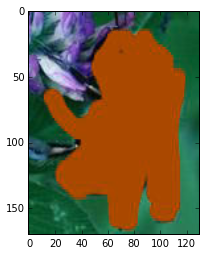

In [17]:
imshow(img_dict['1046'][ymin:ymax+20, xmin:xmax+20])
# cv2.waitKey(0)
# cv2.destroyAllWindows()

#### Read original images into our file

We have pinpointed the blue part in pictures, now we shall use those locations' information to get the bee in those train pictures. we first import all 50 images into the variable

#### TESTING

We used '1046' picture to show that every code works very well before this point. The picture proves that we have succussfully got what we want, then we will read all pictures into the variable.

In [18]:
original_img = cv2.imread('/Users/Grace/not_colored_50/1046.jpg')

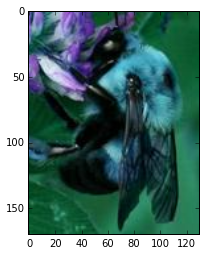

In [19]:
imshow(original_img[ymin:ymax+20, xmin:xmax+20])
# cv2.waitKey(0)
# cv2.destroyAllWindows()

Now, we read all original uncolorred pictures to train the classifier.

In [20]:
img_path_original = '/Users/Grace/not_colored_50/*.jpg'
images_original = glob.glob(img_path_original)
img_dict_original={}
for img_p in images_original:
    k = img_p[img_p.find('50/',)+3:-4]
    img_dict_original[k] = cv2.imread(img_p, cv2.IMREAD_COLOR)

we call the sliding window function again to generate the same amount of windows as in previous steps. In this case, we will extract corresponding windows which contain bees according to the location information we got before.

In [21]:
small_ori_img_dict = dict()
for k in img_dict_original.keys():
    img = img_dict_original[k]
    small_images = sliding_window(img, STEP_SIZE, (WINDOW_SIZE, WINDOW_SIZE)) #windows per image
    small_ori_img_dict[k] = small_images

Here we print all original keys to prove that 50 images are all read in

In [22]:
print img_dict_original.keys() # 49 images
print len(img_dict_original.keys())

['2861', '2614', '3713', '2964', '4654', '4413', '3490', '114', '3573', '395', '4454', '485', '2524', '4703', '4148', '879', '747', '3478', '3344', '2741', '1372', '2401', '4588', '4216', '438', '1130', '952', '99', '3178', '3524', '4566', '3649', '3313', '4052', '2213', '4156', '1046', '4117', '3012', '4507', '940', '2085', '3194', '3844', '1474', '371', '920', '725', '431']
49


In [23]:
len(small_ori_img_dict['952'].keys()) # it's original image, so it's obvious to have 19*19 = 361 windows

361

## 1.3 Flattening Window

Here we need to constuct the dataset. The dataset has the format that each row is one image, and all of this images pixels [r,g,b] will be colums. Each column will be one color, r, g, b, and repeat this order again until all pixels information has listed.

In [24]:
def flatten_rgb_as_column(window):
    window_rgb = []
    for row in window:
        for pixel in row:
            for rgb in pixel:
                window_rgb.append(int(rgb))
    return window_rgb

## 1.3.1 Serialized Version of Flattening Window

In [25]:
start = time.time()
# small_ori_img_dict : (0, 0) : [[...]]
flattened_rgb = [] # (row : 400 * 49, col : 400 * 3)
label = [] # True or False
data_label_dict = []
data_label_list = []

for key in small_ori_img_dict.keys():
    for window, matrix in small_ori_img_dict[key].items():
        if window in all_image[key].keys():
            label.append(all_image[key][window])
            flattened_rgb.append(flatten_rgb_as_column(matrix))
            data_label_list.append([all_image[key][window]]+flatten_rgb_as_column(matrix))
            data_label_dict.append({'label':all_image[key][window], 'features':flatten_rgb_as_column(matrix)})
end = time.time()
s_fl_window_time = end-start
print s_fl_window_time

11.6525518894


In [26]:
print all_image.keys()
print len(all_image.keys())

['2861', '2614', '3713', '2964', '4413', '3490', '4654', '3344', '395', '4454', '485', '2524', '4703', '4148', '879', '371', '747', '3478', '3573', '2741', '1372', '2401', '4588', '4216', '438', '1130', '952', '99', '4117', '3524', '4566', '3649', '4941', '3313', '4052', '2213', '4156', '1046', '3178', '3012', '4507', '940', '2085', '3194', '3844', '1474', '114', '920', '725', '431']
50


In [27]:
print len(flattened_rgb), len(label)

4968 4968


In [28]:
data = np.array([np.array(xi) for xi in flattened_rgb])
y = np.array(label)

In [29]:
import pandas as pd
data_label_df = pd.DataFrame(data_label_dict)

## 1.3.2 Parallelized Version of Flattening Window

In [30]:
'''previously, test_img_window_dict was dictionary, and now we convert it to list of tuples for RDD use '''
start = time.time()

# test_img_window_before_rdd = [ ('2318', (0,0), [[r,g,b],[r,g,b],...]), ... ]
img50_window_before_rdd = []
for key in small_ori_img_dict.keys():
    for window, matrix in small_ori_img_dict[key].items():
        img50_window_before_rdd.append((key,window,matrix))

'''pyspark version for flatten_rgb (parallelized version)'''
# test_img_window_rdd = [('2318', (0,0), matrix), ... ]
img50_window_rdd = sc.parallelize(img50_window_before_rdd)
# test_img_flattened_rdd = [('2318', (0,0), flattended_matrix), ... ]
img50_flattened_rdd = img50_window_rdd.map(lambda (k, window, matrix) : (k, window, flatten_rgb_as_column(matrix)))

img50_flattened_rdd.collect()

end = time.time()

p_fl_window_time = end-start
print p_fl_window_time

16.04895401


## 1.3.3 Performance Testing of Flattening Window

In [31]:
print 'helo'

helo


In [32]:
p_fl_window_time_par = []
num_partitions = [1,2,4,8]
for i in range(len(num_partitions)):

    start = time.time()

    # test_img_window_before_rdd = [ ('2318', (0,0), [[r,g,b],[r,g,b],...]), ... ]
    img50_window_before_rdd = []
    for key in small_ori_img_dict.keys():
        for window, matrix in small_ori_img_dict[key].items():
            img50_window_before_rdd.append((key,window,matrix))

    '''pyspark version for flatten_rgb (parallelized version)'''
    # test_img_window_rdd = [('2318', (0,0), matrix), ... ]
    img50_window_rdd = sc.parallelize(img50_window_before_rdd, num_partitions[i])
    # test_img_flattened_rdd = [('2318', (0,0), flattended_matrix), ... ]
    img50_flattened_rdd = img50_window_rdd.map(lambda (k, window, matrix) : (k, window, flatten_rgb_as_column(matrix)))

    img50_flattened_rdd.collect()

    end = time.time()

    p_fl_window_time_par.append(end-start)
    print "Parallelized Flattening Window time with ", str(num_partitions[i]), ":",p_fl_window_time_par[i], "s"

Parallelized Flattening Window time with  1 : 14.5676109791 s
Parallelized Flattening Window time with  2 : 14.4359600544 s
Parallelized Flattening Window time with  4 : 14.653938055 s
Parallelized Flattening Window time with  8 : 16.4053840637 s


# 2. Classification using Training Data set

## Baseline Model

Baseline models here are for the future comparison purpose. If we just classify everything as bees/not bees, we will get two baseline accurancy boundary. If the classified models' accuracy is lower than these two values. It means we failed to train the model. 

Our baseline_model_1 would be classify all windows as bees.

Our baseline_model_2 would be classify all windows as not bees.

Our classifier should at least beat these two.

In [39]:
# Accuracy of baseline_model_1 (classifiy all windows as bees)
bsl_accuracy = sum(y==True)/float(len(y))

# Accuracy of baseline_model_2 (classifiy all windows as not bees)
bs2_accuracy = sum(y==False)/float(len(y))

print "bs1_accuracy:", bsl_accuracy 
print "bs2_accuracy:", bs2_accuracy 

bs1_accuracy: 0.605475040258
bs2_accuracy: 0.394524959742


So our classifier should at least have a accuracy higher than 0.60404207053.

## 2.1 Serialized Version with External Library
After we have built all baseline models, we will use external libraries to do PCA then KNN and Logistic Regression.

The reason we first to use external libraries to calculate is to get the basic idea what our future results would be like. By using the external libraries, we could also decide which classification method we shall choose for parrallel computing. 

In [26]:
from sklearn.decomposition import PCA

## 2.1.1 PCA

In [43]:
pca = PCA(n_components=60)
X = pca.fit_transform(data)

In [44]:
print pca.explained_variance_ratio_.sum()

0.962965193722


In [45]:
pca.explained_variance_ratio_*100

array([ 51.04792402,   8.07486151,   7.30204928,   6.61658317,
         3.47744995,   2.58977554,   2.25013306,   1.76738551,
         1.15793133,   1.08680291,   0.85620799,   0.76060469,
         0.5888511 ,   0.57170322,   0.53589031,   0.5239252 ,
         0.48756489,   0.39958651,   0.36968581,   0.33917266,
         0.332072  ,   0.29618661,   0.28169665,   0.23920683,
         0.22097666,   0.21727168,   0.2074705 ,   0.2044223 ,
         0.19374724,   0.19230456,   0.18073581,   0.17090282,
         0.16530772,   0.15960202,   0.15225581,   0.14113799,
         0.1284377 ,   0.12189664,   0.12027318,   0.11724018,
         0.11301662,   0.10490533,   0.10221173,   0.09697877,
         0.09454352,   0.09373287,   0.09231355,   0.09158045,
         0.0849841 ,   0.0827884 ,   0.07714678,   0.0759479 ,
         0.07427057,   0.07197231,   0.06880067,   0.0681175 ,
         0.06729148,   0.06437862,   0.06362845,   0.06067618])

The following codes are trying to display those principal components. We want to get a basic idea what those principal components look like. 

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import imshow

In [47]:
dim_x, dim_y = (20, 20)
def normit(a):
    a=(a - a.min())/(a.max() -a.min())
    a=a*256
    return np.round(a)
def getNC(pc, j):
    size=dim_x*dim_y*3
    r=pc.components_[j][0:size:3]
    g=pc.components_[j][1:size:3]
    b=pc.components_[j][2:size:3]
    r=normit(r)
    g=normit(g)
    b=normit(b)
    return r,g,b
def display_component(pc, j):
    r,g,b = getNC(pc,j)
    rgbArray = np.zeros((dim_x, dim_y,3), 'uint8')
    rgbArray[..., 0] = r.reshape(dim_x, dim_y)
    rgbArray[..., 1] = g.reshape(dim_x, dim_y)
    rgbArray[..., 2] = b.reshape(dim_x, dim_y)
    imshow(rgbArray)

In [48]:
STANDARD_SIZE = (dim_x, dim_y)#standardized pixels in image.

In [49]:
def get_image(mat):
    size = STANDARD_SIZE[0]*STANDARD_SIZE[1]*3
    r,g,b = mat[0:size:3], mat[1:size:3],mat[2:size:3]
#     print r, g, b
    rgbArray = np.zeros((STANDARD_SIZE[1],STANDARD_SIZE[0], 3), 'uint8')#3 channels
    rgbArray[..., 0] = r.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    rgbArray[..., 1] = b.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    rgbArray[..., 2] = g.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
#     print rgbArray
    return rgbArray

def display_image(mat):
    imshow(get_image(mat))


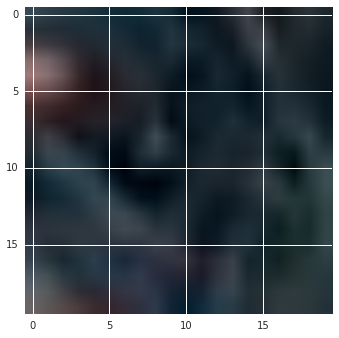

In [50]:
display_image(data[10])

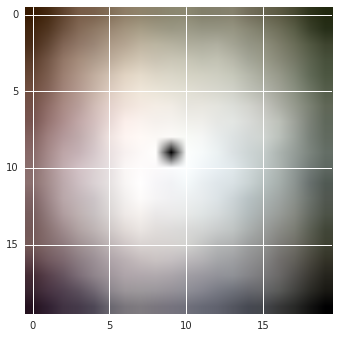

In [51]:
display_component(pca,0)

In [52]:
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

In [53]:
df = pd.DataFrame({"y":y, "label":np.where(y, "T", "F")})
for i in range(pca.explained_variance_ratio_.shape[0]):
    df["pc%i" % (i+1)] = X[:,i]
df.head()

,label,y,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26,pc27,pc28,pc29,pc30,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40,pc41,pc42,pc43,pc44,pc45,pc46,pc47,pc48,pc49,pc50,pc51,pc52,pc53,pc54,pc55,pc56,pc57,pc58,pc59,pc60
0,F,False,-1861.408457,193.618962,-294.021248,-43.707891,110.512696,-161.812753,44.685612,-133.314431,-78.690876,-39.886231,24.674920,59.377155,-62.360768,-60.554309,-283.759711,37.188791,193.060009,-43.650955,90.562202,-86.748335,-55.882476,174.895568,-29.392028,55.806141,61.438090,11.651776,83.121529,53.875173,-93.116478,36.564468,13.883330,-107.120944,-59.337488,-190.409399,-187.845559,40.183818,57.970220,-50.827919,-36.052441,121.088517,-78.153622,-18.490888,-30.076832,-11.148996,-18.368190,-8.903059,-58.210762,-67.257244,31.087464,24.861641,-15.316178,53.345861,96.965932,-94.048363,44.899784,-26.024937,-22.536181,15.464648,-21.435072,-6.520789
1,F,False,-610.920256,888.844010,-98.847244,-967.627518,-288.683369,-219.086599,125.539647,217.827892,-95.416008,190.545427,201.429040,-18.904050,226.610096,-336.178165,171.705753,482.378181,-104.317595,-75.196784,193.065518,147.624092,-108.529324,96.951458,-44.443654,-127.594786,50.838789,-175.258667,-27.493773,78.030851,32.196688,-123.130608,-185.650697,-162.202790,128.744167,-28.165563,63.741490,56.450078,-45.523219,72.077958,13.283468,158.558788,-8.830563,-41.907333,49.671106,-49.946848,12.528223,-10.517976,69.549588,-46.185627,-13.697863,-1.036890,52.089078,-43.966884,-27.801436,90.349236,94.477121,-12.568893,0.417100,-92.782368,41.038369,1.188386
2,F,False,335.717252,1084.194522,-623.989517,-66.006734,-383.402935,95.339435,429.238664,-376.263303,-188.904220,247.859409,249.193375,62.453193,-84.784623,-280.902288,-127.136947,-136.702090,-140.972992,148.385101,193.522604,167.769164,134.730736,47.268459,61.863742,103.816128,137.700711,105.303603,-134.482634,61.027598,81.504237,-19.491198,-21.909992,58.336692,-93.293104,17.924802,4.591896,92.420050,-7.180440,-70.910429,30.698684,-30.517936,-37.438311,52.167536,-46.001311,-9.076004,14.543624,84.472278,-229.517365,-36.516454,-5.176167,14.670437,265.757406,88.008145,23.804445,44.710223,145.341398,-80.542787,-31.927820,-142.465262,42.077934,126.898866
3,F,False,-494.247450,581.190572,-587.614947,584.732759,-202.306494,-4.282742,262.049069,222.240887,-95.298860,13.196930,-204.877094,-87.871427,-59.191414,71.078104,-27.592980,63.491966,-79.475799,48.634884,-180.157539,-17.593529,-182.332526,17.842407,-148.993440,-59.744929,93.453657,7.865193,49.314862,-52.900512,-329.091240,-30.440428,-142.853657,-133.539943,-206.062643,62.076963,228.406412,84.455024,56.925701,-12.361337,-180.525319,-44.161973,-142.070052,-63.702341,-26.874989,-83.545620,-6.604541,-66.704486,3.356768,-89.680339,139.270013,-140.282004,52.322845,65.890572,-131.625867,143.187107,10.390463,135.270243,-66.785943,72.417698,19.806233,-140.071689
4,F,False,-86.565713,963.926846,464.590144,-433.510180,-230.091818,5.568120,690.443293,-108.318344,106.500675,30.930430,388.248676,-71.203715,82.050767,191.050482,301.744920,393.920949,-231.274273,149.273482,135.276298,169.225791,29.325327,-27.346777,88.093345,-68.150293,-217.971287,-111.248820,-134.449582,94.533781,61.884272,161.532567,6.862678,11.812631,-121.776454,381.793288,77.082676,14.551319,41.439464,-133.853004,47.369237,50.059339,-172.720417,23.710456,78.188874,-137.877472,-86.552550,-58.926621,-177.510685,8.135344,-64.785184,149.309714,-94.044016,-57.339716,-72.012797,3.756435,142.489117,-83.261990,4.122467,79.966038,80.604260,66.652704


In [54]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(df.shape[0]), train_size=0.7)

In [55]:
mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [56]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [57]:
from sklearn.grid_search import GridSearchCV

def cv_optimize(clf, parameters, x, y, n_folds, score_func):
    fitmodel = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    fitmodel.fit(x, y)
    print "BEST PARAMS", fitmodel.best_params_
    return fitmodel.best_estimator_

In [58]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [59]:
pca.explained_variance_ratio_.shape[0]

60

## 2.1.2 KNN
######What is KNN?


kNN is a very simple algorithm to diretly use this idea to do classification. If a lot of samples in some area of the feature space belong to one class as compared to the other, we'll label that part of the feature space as "belonging" to that class. This process will then classify the feature space into class-based regions. Then, given the point in feature space, we find which region its in and thus its class. 

The way kNN does this is to ask for the k nearest neighbors in the training set of the new sample. This distance is typically defined as the **Euclidean distance**, the sum of the square of the difference of each feature value between any two samples.

$$D(s_1,s_2) = \sum_f (x_{f1} - x_{f2})^2.$$

Once we have a distance measure, we can sort the distances from the current sample. Then we choose the $k$ closest ones in the training set, where $k$ is an odd number (to break ties) like 1,3,5,...19,. We now see how many of these $k$ "nearest neighbors" belong to one class or the other, and choose the majority class amongst those neighbors as our sample's class.

The training process thus simply consists of memorizing the data, perhaps using a database to aid in the fast lookup of the $k$ nearest training set neighbors of any point in feature space. Notice that this process divides feature space into regions of one class or the other, since one can simply ask what the $k$ nearest neighbors in the training set are of any given point in feature space. Also notice that since classification happens via a majority "voting" scheme, we also know the probability that a point in feature space belongs to a class, as estimated by the fraction of $k$ nearest neighbors to that point in the desired class.




We will import KNN package and do classification and as the result shown below, the accuray is actually higher than our baseline models. As such, the KNN classifier is able to get a good result.



In [60]:
pc_name = [i for i in df.columns[2:4]]

#### KNN (2 pc)

In [61]:
from sklearn.neighbors import KNeighborsClassifier 
clf_knn, Xtrain_k, ytrain_k, Xtest_k, ytest_k = do_classify(KNeighborsClassifier(), 
                                                            {"n_neighbors": range(1,40,2)}, 
                                                            df,pc_name, 'label', 'T', mask=mask)

using mask
BEST PARAMS {'n_neighbors': 39}
############# based on standard predict ################
Accuracy on training data: 0.68
Accuracy on test data:     0.66
[[203 387]
 [114 787]]
########################################################


/Users/Grace/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


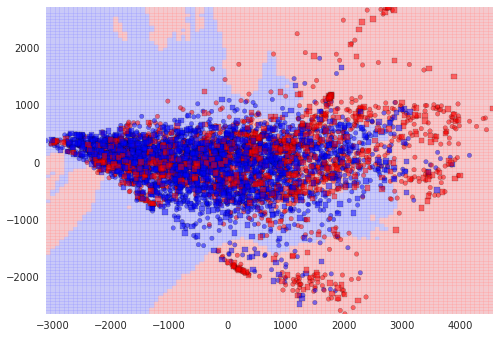

In [89]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain_k, Xtest_k, ytrain_k, ytest_k, clf_knn, alpha=0.5, psize=20);

#### KNN (10 pc)

In [62]:
pc_name = [i for i in df.columns[2:12]]

In [63]:
clf_knn_10, Xtrain_k_10, ytrain_k_10, Xtest_k_10, ytest_k_10 = do_classify(KNeighborsClassifier(), 
                                                            {"n_neighbors": range(1,40,2)}, 
                                                            df,pc_name, 'label', 'T', mask=mask)

using mask
BEST PARAMS {'n_neighbors': 39}
############# based on standard predict ################
Accuracy on training data: 0.78
Accuracy on test data:     0.78
[[409 181]
 [144 757]]
########################################################


/Users/Grace/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


## 2.1.3 Logistic Regression

#### Logistic Regression (2 pc)

In [72]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

In [83]:
pc_name = [i for i in df.columns[2:4]]

In [84]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
                                                           df,pc_name, 'label', 'T', mask=mask)

using mask
BEST PARAMS {'C': 0.1}
############# based on standard predict ################
Accuracy on training data: 0.63
Accuracy on test data:     0.67
[[169 381]
 [118 823]]
########################################################


/Users/Grace/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


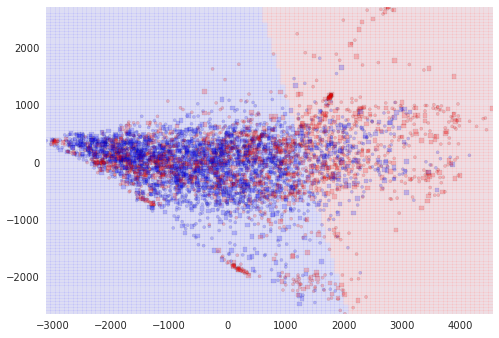

In [85]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clf_l, alpha=0.2);

#### Logistic Regression (10 pc)

In [81]:
pc_name = [i for i in df.columns[2:10]]

In [82]:
clf_l_10, Xtrain_l_10, ytrain_l_10, Xtest_l_10, ytest_l_10  = do_classify(LogisticRegression(), 
                                                           {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
                                                           df,pc_name, 'label', 'T', mask=mask)

using mask
BEST PARAMS {'C': 0.01}
############# based on standard predict ################
Accuracy on training data: 0.72
Accuracy on test data:     0.73
[[309 241]
 [166 775]]
########################################################


/Users/Grace/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


## 2.1.4 Model Comparison using ROC Curve

In [80]:

from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

In [78]:
import seaborn as sns

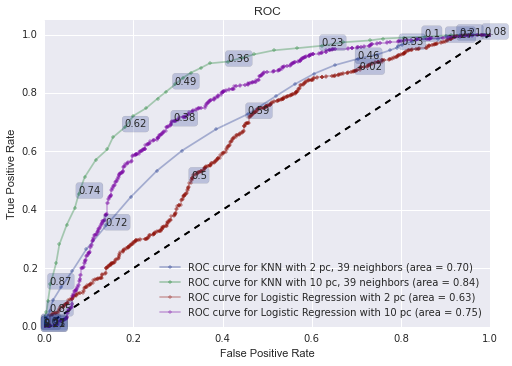

In [90]:
with sns.color_palette("dark"):
    ax=make_roc("KNN with 2 pc, 39 neighbors",clf_knn, ytest_k, Xtest_k)
    make_roc("KNN with 10 pc, 39 neighbors",clf_knn_10, ytest_k_10, Xtest_k_10)
    make_roc("Logistic Regression with 2 pc", clf_l, ytest_l, Xtest_l, ax, labe=250, proba=False)
    make_roc("Logistic Regression with 10 pc", clf_l_10, ytest_l_10, Xtest_l_10, ax, labe=250, proba=False)

** Based on the result we got from external library serialized version, KNN
gives us a better result than logistic regression and both classifier beat the baseline model.
Now we will implement our own serialized PCA and KNN version first.
And then we will implement a parallelized version of PCA and KNN. 
At last, we will compare the performance of the two version.**

## 2.2 Serialized Implementation

## 2.2.1 PCA
###Why do we have to write our own PCA function?

In order to compare the speed-up after we implement the parallel version, we have to write our own serialized version, as the package is the very fine code performancewise.  

In [64]:
import numpy as np
def getCovMatrix(data):
    nrow = len(data)
    cov_input=[]
    for i in range(len(data)):
        cov_input.append(data[i,:])
    cov_mat = np.cov(cov_input)
    
    return cov_mat

In [65]:
def ser_pca(data, k):
    
    X = data.T
    cov_mat = getCovMatrix(X)
    nrow = len(X)
    
    # eigenvectors and eigenvalues for the from the covariance matrix
    eig_val_cov, eig_vec_cov = np.linalg.eig(cov_mat)
    
    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:,i]) for i in range(len(eig_val_cov))]

    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eig_pairs.sort()
    eig_pairs.reverse()
    
    kdim = []
    for i in range(k):
        kdim.append(eig_pairs[i][1].reshape(nrow,1))
        
    matrix_w = np.hstack(kdim)
    transformed_X = matrix_w.T.dot(X)
    transformed_data = transformed_X.T
    
    return transformed_data

In [66]:
import time
start = time.time()
X_s= ser_pca(data,10) # reduce the 1200 features to 10 principal components
end = time.time()

serialized_PCA_time = end-start
print "Serialized PCA time:",serialized_PCA_time, "s"

Serialized PCA time: 3.27673602104 s


## 2.2.2 KNN
### Serialized implementation of KNN in python (no external library)

The reason we wrote our own KNN implementation is the same as we have discussed above. Doing this is for the future comparison reason

In [67]:
import random
import math
import operator

In [68]:
def euclideanDistance(instance1, instance2, length):
    distance = 0
    for x in range(length):
        distance += pow((instance1[x] - instance2[x]), 2)
    return math.sqrt(distance)

In [69]:
def getNeighborsResponse(Xtrain, XtestInstance, ytrain, k):
    distances = []
    length = len(XtestInstance)-1
    for x in range(len(Xtrain)):
        dist = euclideanDistance(XtestInstance, Xtrain[x], length)
        distances.append(dist)
    # sort label(ytrain) by the order of distance
    neighbor = [x for (y,x) in sorted(zip(distances,ytrain))]
    # get the label of the top k neighbors
    responses = neighbor[0:k]
    # use the average of the neighbors' responses as our result
    predict = int(math.ceil(np.mean(responses)))
    
    return predict

In [70]:
def getAccuracy(ytest, predictions):
    correct = 0
    for x in range(len(ytest)):
        if ytest[x] == predictions[x]:
            correct += 1
    return (correct/float(len(ytest)))

In [71]:
Xtrain_s, Xtest_s, ytrain_s, ytest_s = train_test_split(X_s, y, train_size=0.8)

In [72]:
import time
start = time.time()
# generate predictions
predictions=[]
k = 7 # from previous result

for x in range(len(Xtest_s)):
    result = getNeighborsResponse(Xtrain_s, Xtest_s[x], ytrain_s, k)
    predictions.append(result)
accuracy = getAccuracy(ytest_s, predictions)
print('Accuracy: ' + repr(accuracy) )
end = time.time()

serialized_KNN_time = end-start
print "Serialized KNN time:",serialized_KNN_time, "s"

Accuracy: 0.7303822937625755
Serialized KNN time: 31.1163220406 s


##Conclusion

As we have expected, the serialized code we wrote has very bad performance compared the package's one. The package's code may contain C code to speed up. When we wrote everything in Python, the performance gets much worse. 

Another thing we have noticed is the accuracy is off from the one we got before, since we didn't implement cross-validation here. Doing cross-validation in serialized way is beyond the scope of our project, and beyond our ability. 

One thing needs to emphasize is even with cross-validation, the external package still reach higher performance.


## 2.3 Parallelized Implementation

## 2.3.1 PCA

In [73]:
from pyspark.ml.feature import PCA
from pyspark.mllib.linalg import Vectors
from pyspark.sql import SQLContext
from pyspark.mllib.feature import Normalizer
sqlContext = SQLContext(sc)

In [74]:
import numpy as np

def estimateCovariance(df):
    
    m = df.select(df['features']).map(lambda x: x[0]).mean()
    dfZeroMean = df.select(df['features']).map(lambda x:   x[0]).map(lambda x: x-m)  # subtract the mean
    cov = dfZeroMean.map(lambda x: np.outer(x,x)).sum()/df.count()
    
    return cov

In [75]:
from numpy.linalg import eigh

def p_pca(df, k=2):
    
    cov = estimateCovariance(df)
    col = cov.shape[1]
    eigVals, eigVecs = eigh(cov)
    inds = np.argsort(eigVals)
    eigVecs = eigVecs.T[inds[-1:-(col+1):-1]]  
    components = eigVecs[0:k]
    eigVals = eigVals[inds[-1:-(col+1):-1]]  # sort eigenvals
    score = df.select(df['features']).map(lambda x: x[0]).map(lambda x: np.dot(x, components.T) )
    # Return the `k` principal components, `k` scores, and all eigenvalues

    return components.T, score, eigVals

In [76]:
def varianceExplained(eigVals, k):
    var_exp = sum(eigVals[0:k])/sum(eigVals)
    
    return var_exp

In [77]:
df_train, df_test, label_train, label_test = train_test_split(flattened_rgb,label, train_size=0.8)

In [78]:
# construct feature rdd dataframe
data=sc.parallelize([(Vectors.dense(xi),) for xi in flattened_rgb])
df_rdd = sqlContext.createDataFrame(data,["features"])

num_principal_component = 10

start = time.time()
comp, score, eigVals = p_pca(df_rdd, k=num_principal_component)
end = time.time()
parallelized_PCA_time = end-start

print "Parallelized PCA time:",parallelized_PCA_time, "s"

Parallelized PCA time: 98.88072896 s


In [109]:
varianceExplained(eigVals, num_principal_component)

0.85370896280001418

## 2.3.2 KNN

In [113]:
# generate predictions
predictions=[]
k = 7 # from previous result

Xtest_n_rdd = sc.parallelize(Xtest_s)
ytest_n_rdd = sc.parallelize(ytest_s)

start = time.time()
predict_n_rdd = Xtest_n_rdd.map(lambda x: getNeighborsResponse(Xtrain_s, x, ytrain_s, k))
pred_actual_pair = predict_n_rdd.zip(ytest_n_rdd)

correct = pred_actual_pair.map(lambda (pred, obs): int(obs==pred)).reduce(lambda a,x: a+x)
end = time.time()

# calculate the accuracy
accuracy = correct/float(len(ytest_n))

print('Accuracy: ' + repr(accuracy) )

Parallelized_KNN_time = end-start
print "Parallelized KNN time:",Parallelized_KNN_time, "s"

Accuracy: 0.710261569416499
Parallelized KNN time: 27.4008860588 s


## 2.4 Performance Testing

## 2.4.1 PCA

### Parallelied PCA Performance testing (Train data) with different number of partitions

In [109]:
p_PCA_time_par = []
num_partitions = [1,2,4,8]
for i in range(len(num_partitions)):
    data=sc.parallelize([(Vectors.dense(xi),) for xi in flattened_rgb],num_partitions[i])
    df_rdd = sqlContext.createDataFrame(data,["features"])
    
    start = time.time()
    comp, score, eigVals = p_pca(df_rdd, k=num_principal_component)
    end = time.time()
    
    p_PCA_time_par.append(end-start)
    print "Parallelized PCA time with ", str(num_partitions[i]), ":",p_PCA_time_par[i], "s"

Parallelized PCA time with  1 : 59.9683408737 s
Parallelized PCA time with  2 : 62.4677379131 s
Parallelized PCA time with  4 : 65.0484189987 s
Parallelized PCA time with  8 : 65.1653580666 s


## 2.4.2 KNN

### Parallelied KNN Performance testing (Train data) with different number of partitions

In [113]:
p_KNN_time_par = []
num_partitions = [1,2,4,8]
for i in range(len(num_partitions)):
    
    Xtest_n_rdd = sc.parallelize(Xtest_n, num_partitions[i])
    ytest_n_rdd = sc.parallelize(ytest_n, num_partitions[i])
    
    start = time.time()
    predict_n_rdd = Xtest_n_rdd.map(lambda x: getNeighborsResponse(Xtrain_n, x, ytrain_n, k))
    pred_actual_pair = predict_n_rdd.zip(ytest_n_rdd)
    correct = pred_actual_pair.map(lambda (pred, obs): int(obs==pred)).reduce(lambda a,x: a+x)
    end = time.time()
    
    p_KNN_time_par.append(end-start)
    print "Parallelized KNN time with ", str(num_partitions[i]), ":",p_KNN_time_par[i], "s"

Parallelized KNN time with  1 : 39.2606649399 s
Parallelized KNN time with  2 : 39.3459529877 s
Parallelized KNN time with  4 : 38.5545709133 s
Parallelized KNN time with  8 : 37.960144043 s


# 3. Image Processing for Whole Data set

## Read Test Data set (5,000 images)
In this cell, we'll read 5,000 test data set images as the way we did for 50-labeled-train dataset.

In [79]:
test_img_path = '/Users/Grace/bee_images/train/*.jpg'
test_images = glob.glob(test_img_path)
test_img_dict={}

for img_p in test_images:
    k = img_p[img_p.find('train/',)+6:-4]
    test_img_dict[k] = cv2.imread(img_p, cv2.IMREAD_COLOR)

In [80]:
# to see if images were saved well
print test_img_dict.keys()[:10]
print test_img_dict['2318'].shape
print len(test_img_dict.keys())

['4446', '593', '4447', '4026', '3724', '4024', '4025', '4022', '4023', '3725']
(200, 200, 3)
3969


## 3.1 Sliding Window

test_img_dict contains all information of 5000 images. It will work the same as above.

In [81]:
test_img_window_dict = dict() # derived from small_img_dict = dict()
for k in test_img_dict.keys():
    img = test_img_dict[k]
    window_image = sliding_window(img, STEP_SIZE, (WINDOW_SIZE, WINDOW_SIZE)) #windows per image
    test_img_window_dict[k] = window_image

In [82]:
print len(test_img_window_dict['2318'].keys()) # it should be 361 windows 
print test_img_window_dict['2318'][(30,60)].shape # it should be (20, 20, 3)

361
(20, 20, 3)


## 3.2 Flattening Window

We'll flatten 5000 test data as the way we did above.

## 3.3.1 Serialized Version of Flattening Window

In [123]:
start = time.time()
# small_ori_img_dict : (0, 0) : [[...]]
flattened_rgb_for_5000 = [] # (row : 400 * 49, col : 400 * 3)

for key in test_img_window_dict.keys():
    for window, matrix in test_img_window_dict[key].items():
        flattened_rgb_for_5000.append(flatten_rgb_as_column(matrix))


end = time.time()
s_fl_5000_time = end-start
print s_fl_5000_time

11345.3720949


In [124]:
data_5000 = np.array([np.array(xi) for xi in flattened_rgb_for_5000])

## 3.3.2 Parallelized Version of Flattening Window

In [33]:
'''previously, test_img_window_dict was dictionary, and now we convert it to list of tuples for RDD use '''
# test_img_window_before_rdd = [ ('2318', (0,0), [[r,g,b],[r,g,b],...]), ... ]
test_img_window_before_rdd = []
for key in test_img_window_dict.keys():
    for window, matrix in test_img_window_dict[key].items():
        test_img_window_before_rdd.append((key,window,matrix))

'''pyspark version for flatten_rgb (parallelized version)'''
# test_img_window_rdd = [('2318', (0,0), matrix), ... ]
test_img_window_rdd = sc.parallelize(test_img_window_before_rdd)
# test_img_flattened_rdd = [('2318', (0,0), flattended_matrix), ... ]
test_img_flattened_rdd = test_img_window_rdd.map(lambda (k, window, matrix) : (k, window, flatten_rgb_as_column(matrix)))

## 3.3.3 Performance Testing of Flattening Window

In [34]:
p_fl_5000_time_par = []
num_partitions = [1,2,4,8]
for i in range(len(num_partitions)):

    start = time.time()

    # test_img_window_before_rdd = [ ('2318', (0,0), [[r,g,b],[r,g,b],...]), ... ]
    test_img_window_before_rdd = []
    for key in test_img_window_dict.keys():
        for window, matrix in test_img_window_dict[key].items():
            test_img_window_before_rdd.append((key,window,matrix))
    '''pyspark version for flatten_rgb (parallelized version)'''
    # test_img_window_rdd = [('2318', (0,0), matrix), ... ]
    test_img_window_rdd = sc.parallelize(test_img_window_before_rdd, num_partitions[i])
    # test_img_flattened_rdd = [('2318', (0,0), flattended_matrix), ... ]
    test_img_flattened_rdd = test_img_window_rdd.map(lambda (k, window, matrix) : (k, window, flatten_rgb_as_column(matrix)))

    test_img_flattened_rdd.collect()

    end = time.time()

    p_fl_5000_time_par.append(end-start)
    print "Parallelized Flattening Window time with ", str(num_partitions[i]), ":",p_fl_5000_time_par[i], "s"

# 4. Apply Classifier to Whole Data set

## 4.1 PCA Performance Testing

#### Serialized Version

In [116]:
start = time.time()
X_s= ser_pca(data_5000,10) # reduce the 1200 features to 10 principal components
end = time.time()

serialized_PCA_time_5000 = end-start
print "Serialized PCA time:",serialized_PCA_time_5000, "s"

Serialized PCA time: 2.2384159565 s


#### Parallelized Version

In [35]:
# construct feature rdd dataframe
data_5000_rdd=sc.parallelize([(Vectors.dense(xi),) for xi in flattened_rgb_for_5000])
df_rdd_5000 = sqlContext.createDataFrame(data_5000_rdd,["features"])

num_principal_component = 10

start = time.time()
comp, score, eigVals = p_pca(df_rdd_5000, k=num_principal_component)
end = time.time()
parallelized_PCA_time = end-start

print "Parallelized PCA time:",parallelized_PCA_time, "s"

#### Parallelized version performance testing with different number of partitions

In [37]:
p_PCA_time_par_5000 = []
num_partitions = [1,2,4,8]
for i in range(len(num_partitions)):
    data_5000_rdd=sc.parallelize([(Vectors.dense(xi),) for xi in flattened_rgb_for_5000],num_partitions[i])
    df_rdd_5000 = sqlContext.createDataFrame(data_5000_rdd,["features"])
    
    start = time.time()
    comp, score, eigVals = p_pca(df_rdd_5000, k=num_principal_component)
    end = time.time()
    
    p_PCA_time_par_5000.append(end-start)
    print "Parallelized PCA time with ", str(num_partitions[i]), ":",p_PCA_time_par_5000[i], "s"

## 4.2 KNN Performance Testing

#### Serialized Version

In [38]:
start = time.time()
# generate predictions
predictions=[]
k = 7 # from previous result

for x in range(len(X_s)):
    result = getNeighborsResponse(Xtrain_s, X_s[x], ytrain_s, k)
    predictions.append(result)

end = time.time()

serialized_KNN_time_5000 = end-start
print "Serialized KNN time:",serialized_KNN_time_5000, "s"

#### Parallelized Version

In [39]:
# generate predictions
predictions=[]
k = 7 # from previous result

Xtest_5000_rdd = sc.parallelize(X_s)

start = time.time()

predict_5000_rdd = Xtest_5000_rdd.map(lambda x: getNeighborsResponse(Xtrain_n, x, ytrain_n, k))
predict_5000_rdd.collect() 

end = time.time()

Parallelized_KNN_time_5000 = end-start
print "Parallelized KNN time:",Parallelized_KNN_time_5000, "s"

#### Parallelized version performance testing with different number of partitions

In [40]:
p_KNN_time_par_5000 = []
num_partitions = [1,2,4,8]
for i in range(len(num_partitions)):
    
    Xtest_5000_rdd = sc.parallelize(X_s, num_partitions[i])
    
    start = time.time()

    predict_5000_rdd = Xtest_5000_rdd.map(lambda x: getNeighborsResponse(Xtrain_n, x, ytrain_n, k))
    predict_5000_rdd.collect() 

    end = time.time()
    
    p_KNN_time_par_5000.append(end-start)
    print "Parallelized KNN time with ", str(num_partitions[i]), ":",p_KNN_time_par_5000[i], "s"